# MATH 493 Group Project: Predicting Churners

We create several logistic regression and decision tree models as tools to predict whether a merchant will stop making purchases.

Grace Flitsch, Lilly Nikkel, Carson Slater, Carrie Snodgrass

Advised by: Dr. Ying Li

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Importing packages.

In [2]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns

import statsmodels.api as sm


Utility Functions
- @author Ying Li, Carrie Snodgrass, Lilly Nikkel, Grace Flitsch
- PRECONDITIONS: various
- POSTCONTITIONS: various
- PARAMETERS: various


In [3]:
def prep_data(filename, dropna,datecol):
    baskets = pd.read_csv(filename, parse_dates = [datecol])
    if dropna:
        baskets.dropna(inplace=True)
    for s in baskets.columns:
        if ("id" in s):
            baskets.loc[:,s] = baskets.loc[:,s].astype(int)
            #baskets.loc[:,s] = pd.Categorical(baskets.loc[:,s].apply(lambda x: floor(x))) 
            # -- making them into categorical has undesirable effect
    if datecol:
        baskets['date'] = baskets[datecol].dt.date
        baskets['year'] = baskets[datecol].dt.year
        baskets['month'] = baskets[datecol].dt.month
        baskets['month1'] = baskets[datecol].apply(lambda t: t.strftime("%Y-%m"))
        baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
        baskets['week_num'] = baskets[datecol].dt.isocalendar().week
        baskets['week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
        baskets['week1'] = baskets[datecol].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
        baskets.loc[baskets['week_num']==104,'week_num'] = 52
        baskets['day'] = baskets[datecol].dt.day
        baskets['hour'] = baskets[datecol].dt.hour
        baskets['weekday'] = baskets[datecol].dt.weekday
        baskets["spent"] = baskets["qty"] * baskets["price"]
    return baskets

def get_merchant_attributes(baskets):
    merchant_attributes = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
        quantity_purchased = ('qty', 'sum')
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    merchant_attributes['avg_units_per_order'] = merchant_attributes.quantity_purchased / merchant_attributes.num_orders
    
    merchant_attributes.loc[merchant_attributes['last_month'] <= 19, 'churner'] = 1.0 
    merchant_attributes.loc[merchant_attributes['last_month'] > 19, 'churner'] = 0.0  # creating churning category
   
    return merchant_attributes


def get_merchant_order_attributes(baskets):
    merchant_order_attributes = baskets.groupby(['merchant_id', 'order_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
        quantity_purchased = ('qty', 'sum')
    ).reset_index()
    merchant_order_attributes['avg_spent_per_order'] = merchant_order_attributes.total_spent / merchant_order_attributes.num_orders
    merchant_order_attributes['tenure_month'] = merchant_order_attributes.last_month - merchant_order_attributes.first_month +1
    merchant_order_attributes['avg_units_per_order'] = merchant_order_attributes.quantity_purchased / merchant_order_attributes.num_orders
    
    merchant_order_attributes.loc[merchant_order_attributes['last_month'] <= 19, 'churner'] = 1.0 
    merchant_order_attributes.loc[merchant_order_attributes['last_month'] > 19, 'churner'] = 0.0  # creating churning category
   
    return merchant_order_attributes


def get_merchant_attributes2(merchant_orders):
    merchant_attributes = merchant_orders.groupby(['merchant_id']).agg(
        total_spent = ('total_spent', 'sum'), 
        num_orders = ('num_orders', 'sum'), 
        first_month = ('first_month', 'min'), 
        last_month = ('last_month', 'max'), 
        avg_unique_sku_per_order = ('num_skus','mean'), 
        avg_unique_top_cat_per_order = ('num_top_cats','mean'), 
        avg_unique_sub_cat_per_order = ('num_sub_cats','mean'),
        quantity_purchased = ('quantity_purchased', 'sum')
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    merchant_attributes['avg_units_per_order'] = merchant_attributes.quantity_purchased / merchant_attributes.num_orders
    
    merchant_attributes.loc[merchant_attributes['last_month'] <= 17, 'churner'] = 1.0 
    merchant_attributes.loc[merchant_attributes['last_month'] > 17, 'churner'] = 0.0  # creating churning category
   
    return merchant_attributes


def get_order_attributes(baskets):
    order_attributes = baskets.groupby(['order_id']).agg(
        merchant_id = ('merchant_id','max'),
        total_spent = ('spent', 'sum'), 
        quantity_purchased = ('qty', 'sum'),
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
        month = ('month_num', 'max')
    ).reset_index()
    return order_attributes

def time_since():
  baskets.placed_at.sort_values(ascending = False)
  baskets['intermediate'] = baskets.groupby(by='merchant_id').placed_at.diff()

def time_since2():
  test_baskets.placed_at.sort_values(ascending = False)
  test_baskets['intermediate'] = test_baskets.groupby(by = 'merchant_id').placed_at.diff()

def prep_days_since(baskets):
      baskets['days_since'] = baskets['since'].dt.days
      return baskets 

### YINGLI:
* comments on the functions in the above cell
* avg per order attributes in merchant_order_attribute does not make sense because it is by order, so num_order ==1

* these below three functions should be combined into one
* the call to baskets.placed_at.sort_values actually had no impact when you did not save the returns
* you should not sort a single columns and then operate on the whole dataframe which was not sorted at all
* in the case of awantunai data because it is somewhat sorted by "placed_at" in the raw data, this may have worked incidentally 

### Getting Familiar with Dataset

We prepare the data by reading the file, removing empty values, and separating the placed_at field into multiple time fields.

In [4]:
baskets = prep_data('new_baskets_adhie.csv', True, 'placed_at')

New dataframe for testing predictive models on other data (all attributes associated with this dataframe begin with test_...)

In [5]:
test_baskets = prep_data('new_baskets_full.csv', True, 'placed_at')

We aggregate the data around merchants.

In [6]:
merchants = get_merchant_attributes(baskets)

In [7]:
test_merchants = get_merchant_attributes(test_baskets)

Merchants basket has churner column from merchant_attributes.

We aggregate the data around orders.

In [8]:
orders = get_order_attributes(baskets[baskets['month_num']<19])

In [9]:
test_orders = get_order_attributes(test_baskets[test_baskets['month_num']<19])

### Adding a column for time since previous order

'since' column indicates the time since the previous order for that merchant

In [10]:
time_since()

In [11]:
time_since2()

In [12]:
time2 = test_baskets.groupby(by='order_id').agg(
    since = ('intermediate', 'max'))

In [13]:
time = baskets.groupby(by='order_id').agg(
    since = ('intermediate','max'))

In [14]:
time

,since
order_id,
1,0 days 00:00:00
2,0 days 00:00:00
3,0 days 00:00:00
4,0 days 00:36:04.004000
5,0 days 01:18:14.269000
...,...
41580,1 days 01:17:37.453000
41581,0 days 00:15:33.509000
41582,2 days 00:16:55.420000


### YINGLI:
* comments on results of "time"
* After running “since”, I ran query: time.loc[time.since.isna()]
* obtained 12 rows of order IDs that have "since" of value "NaT" 
* It is very confusing to me why these 12 orders got NaT but not others
* I double checked to see if these orders are the only order and has only one SKU for some merchants, but it is not the case
* since you also executed "dropna" later before modeling, you drop the first order for each merchant to start with, to maintain consistency and clear logic

order_id since

11	NaT

60	NaT

3630	NaT

4182	NaT

7364	NaT

7378	NaT

7632	NaT

7640	NaT

10390	NaT

12321	NaT

13550	NaT

13658	NaT


In [16]:
orders.set_index(keys='order_id')

,merchant_id,total_spent,quantity_purchased,num_skus,num_top_cats,num_sub_cats,month
order_id,,,,,,,
1,9,1541000.0,6,4,1,1,6
2,10,185500.0,10,2,1,1,6
3,11,1472500.0,23,9,3,4,6
4,11,549000.0,3,3,2,2,6
5,11,116000.0,1,1,1,1,6
...,...,...,...,...,...,...,...
30019,190,925000.0,7,3,1,1,18
30020,46,243000.0,3,2,2,2,18
30021,190,617000.0,7,4,2,2,18


In [17]:
test_orders.set_index(keys = 'order_id')

,merchant_id,total_spent,quantity_purchased,num_skus,num_top_cats,num_sub_cats,month
order_id,,,,,,,
1,58,16921950.0,394,44,15,24,18
2,46,414270000.0,2380,8,2,3,4
3,61,415100000.0,2300,7,2,4,4
4,80,473650000.0,2650,8,2,4,4
5,36,380900000.0,2000,7,2,4,4
...,...,...,...,...,...,...,...
57647,76,830500.0,23,5,3,4,18
57649,1587,981500.0,9,5,3,3,18
57653,1961,1147400.0,67,4,4,4,18


In [18]:
orders2 = orders.merge(time, on ='order_id')

In [19]:
test_orders2 = test_orders.merge(time2, on = 'order_id')

# Making final dataframe

### YINGLI:
* comments about the concept and computation of "since'
* the variable "since" created this way has zero for the merchant's first order in history, but it should not be zero.
* should it be NaT? or should it be artificially set to a huge value to indicate the first order that has no logical definition of "since"
* or should the first order of earch merchant be discarded because you want to predict churn and we should not be predicting churn on the first order? 

In [20]:
orders2.head()

,order_id,merchant_id,total_spent,quantity_purchased,num_skus,num_top_cats,num_sub_cats,month,since
0,1,9,1541000.0,6,4,1,1,6,0 days 00:00:00
1,2,10,185500.0,10,2,1,1,6,0 days 00:00:00
2,3,11,1472500.0,23,9,3,4,6,0 days 00:00:00
3,4,11,549000.0,3,3,2,2,6,0 days 00:36:04.004000
4,5,11,116000.0,1,1,1,1,6,0 days 01:18:14.269000


### YINGLI 
* commnets on below cells
* the switch over to use df to name the dataframces makes it hard to follow the code
* it does not help to follow because there are multiple concepts here: orders, merchants, baskets, and for two different raw datasets

In [21]:
df = orders2

In [22]:
df2 = test_orders2

In [23]:
df = df.drop(columns =['num_top_cats', 'num_sub_cats'])

In [24]:
df

,order_id,merchant_id,total_spent,quantity_purchased,num_skus,month,since
0,1,9,1541000.0,6,4,6,0 days 00:00:00
1,2,10,185500.0,10,2,6,0 days 00:00:00
2,3,11,1472500.0,23,9,6,0 days 00:00:00
3,4,11,549000.0,3,3,6,0 days 00:36:04.004000
4,5,11,116000.0,1,1,6,0 days 01:18:14.269000
...,...,...,...,...,...,...,...
30007,30019,190,925000.0,7,3,18,0 days 00:19:09.405000
30008,30020,46,243000.0,3,2,18,3 days 08:30:27.796000
30009,30021,190,617000.0,7,4,18,0 days 00:11:32.835000
30010,30022,206,10627000.0,59,22,18,1 days 00:15:58.007000


In [25]:
df2 = df2.drop(columns = ['num_top_cats', 'num_sub_cats'])

In [26]:
df2

,order_id,merchant_id,total_spent,quantity_purchased,num_skus,month,since
0,1,58,16921950.0,394,44,18,181 days 04:40:25.142000
1,2,46,414270000.0,2380,8,4,0 days 00:00:00
2,3,61,415100000.0,2300,7,4,0 days 00:00:00
3,4,80,473650000.0,2650,8,4,0 days 00:00:00
4,5,36,380900000.0,2000,7,4,0 days 00:00:00
...,...,...,...,...,...,...,...
57481,57647,76,830500.0,23,5,18,1 days 02:57:57.525000
57482,57649,1587,981500.0,9,5,18,0 days 00:06:13.870000
57483,57653,1961,1147400.0,67,4,18,0 days 22:22:31.521000
57484,57655,2112,124500.0,1,1,18,0 days 00:03:27.197000


In [27]:
df['churner'] = 0

In [28]:
df2['churner'] = 0
df2['c_tenure'] = 0

### YINGLI:
* this below could have been easily cleaned up by putting together with the setting of "churner" variable

In [29]:
df['c_tenure'] = 0

Getting churn and tenure info from merchants and assigning it to the final dataframe

### YINGLI:
* the below element wise operation is always much slower
* it would be faster to do column/dataframe wise operation 
* the below could be done by setting "merchant_id" as index on order table and join with merchant table to get the churn and first_month columns
* overall, the order table preparation should be combined into the funtion of "get_order_attributes"


In [30]:
for index in df.index:
  row = df.loc[index]
  row['churner'] = (merchants[merchants['merchant_id']== row['merchant_id']]).churner
  row['c_tenure'] = row['month'] - (merchants[merchants['merchant_id']== row['merchant_id']]).first_month 
  df.loc[index] = row

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_22112/450304214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['churner'] = (merchants[merchants['merchant_id']== row['merchant_id']]).churner
/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_22112/450304214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['c_tenure'] = row['month'] - (merchants[merchants['merchant_id']== row['merchant_id']]).first_month


In [31]:
for index in df2.index:
  row = df2.loc[index]
  row['churner'] = (test_merchants[test_merchants['merchant_id']== row['merchant_id']]).churner
  row['c_tenure'] = row['month'] - (test_merchants[test_merchants['merchant_id']== row['merchant_id']]).first_month 
  df2.loc[index] = row

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_22112/1649858472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['churner'] = (test_merchants[test_merchants['merchant_id']== row['merchant_id']]).churner
/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_22112/1649858472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['c_tenure'] = row['month'] - (test_merchants[test_merchants['merchant_id']== row['merchant_id']]).first_month


We use the since category to create a days since variable, measuring the days since last order, as an integer. 

In [32]:
df = prep_days_since(df)
df

,order_id,merchant_id,total_spent,quantity_purchased,num_skus,month,since,churner,c_tenure,days_since
0,1,9,1541000.0,6,4,6,0 days 00:00:00,0,0,0.0
1,2,10,185500.0,10,2,6,0 days 00:00:00,1,0,0.0
2,3,11,1472500.0,23,9,6,0 days 00:00:00,0,0,0.0
3,4,11,549000.0,3,3,6,0 days 00:36:04.004000,0,0,0.0
4,5,11,116000.0,1,1,6,0 days 01:18:14.269000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
30007,30019,190,925000.0,7,3,18,0 days 00:19:09.405000,0,8,0.0
30008,30020,46,243000.0,3,2,18,3 days 08:30:27.796000,0,9,3.0
30009,30021,190,617000.0,7,4,18,0 days 00:11:32.835000,0,8,0.0
30010,30022,206,10627000.0,59,22,18,1 days 00:15:58.007000,0,8,1.0


### YINGLI:
* below experimental code should have been cleaned up

In [33]:
df_save = df

In [34]:
df = df.reset_index(drop=True)

In [35]:
df = df.set_index(keys='order_id')

In [36]:
df

,merchant_id,total_spent,quantity_purchased,num_skus,month,since,churner,c_tenure,days_since
order_id,,,,,,,,,
1,9,1541000.0,6,4,6,0 days 00:00:00,0,0,0.0
2,10,185500.0,10,2,6,0 days 00:00:00,1,0,0.0
3,11,1472500.0,23,9,6,0 days 00:00:00,0,0,0.0
4,11,549000.0,3,3,6,0 days 00:36:04.004000,0,0,0.0
5,11,116000.0,1,1,6,0 days 01:18:14.269000,0,0,0.0
...,...,...,...,...,...,...,...,...,...
30019,190,925000.0,7,3,18,0 days 00:19:09.405000,0,8,0.0
30020,46,243000.0,3,2,18,3 days 08:30:27.796000,0,9,3.0
30021,190,617000.0,7,4,18,0 days 00:11:32.835000,0,8,0.0


In [37]:
df_save

,order_id,merchant_id,total_spent,quantity_purchased,num_skus,month,since,churner,c_tenure,days_since
0,1,9,1541000.0,6,4,6,0 days 00:00:00,0,0,0.0
1,2,10,185500.0,10,2,6,0 days 00:00:00,1,0,0.0
2,3,11,1472500.0,23,9,6,0 days 00:00:00,0,0,0.0
3,4,11,549000.0,3,3,6,0 days 00:36:04.004000,0,0,0.0
4,5,11,116000.0,1,1,6,0 days 01:18:14.269000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
30007,30019,190,925000.0,7,3,18,0 days 00:19:09.405000,0,8,0.0
30008,30020,46,243000.0,3,2,18,3 days 08:30:27.796000,0,9,3.0
30009,30021,190,617000.0,7,4,18,0 days 00:11:32.835000,0,8,0.0
30010,30022,206,10627000.0,59,22,18,1 days 00:15:58.007000,0,8,1.0


In [38]:
df2 = prep_days_since(df2)

In [39]:
df2

,order_id,merchant_id,total_spent,quantity_purchased,num_skus,month,since,churner,c_tenure,days_since
0,1,58,16921950.0,394,44,18,181 days 04:40:25.142000,1,6,181.0
1,2,46,414270000.0,2380,8,4,0 days 00:00:00,1,0,0.0
2,3,61,415100000.0,2300,7,4,0 days 00:00:00,1,0,0.0
3,4,80,473650000.0,2650,8,4,0 days 00:00:00,1,0,0.0
4,5,36,380900000.0,2000,7,4,0 days 00:00:00,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
57481,57647,76,830500.0,23,5,18,1 days 02:57:57.525000,0,0,1.0
57482,57649,1587,981500.0,9,5,18,0 days 00:06:13.870000,1,6,0.0
57483,57653,1961,1147400.0,67,4,18,0 days 22:22:31.521000,0,3,0.0
57484,57655,2112,124500.0,1,1,18,0 days 00:03:27.197000,0,0,0.0


We split the dataframe into train and test partitions.

In [40]:
train, test,= train_test_split(df, test_size=0.2)
train

,merchant_id,total_spent,quantity_purchased,num_skus,month,since,churner,c_tenure,days_since
order_id,,,,,,,,,
10600,59,542000.0,6,6,12,0 days 00:16:13.324000,0,3,0.0
20252,76,3064000.0,12,12,15,1 days 23:33:13.091000,0,5,1.0
29567,62,6297500.0,38,23,18,3 days 00:02:37.029000,0,9,3.0
28535,180,3821000.0,36,26,18,0 days 22:27:54.197000,0,8,0.0
11379,206,12020000.0,42,6,13,1 days 01:37:17.488000,0,3,1.0
...,...,...,...,...,...,...,...,...,...
7195,94,873000.0,14,8,11,2 days 00:46:58.501000,0,1,2.0
29848,190,245500.0,32,5,18,0 days 00:02:29.812000,0,8,0.0
6715,190,566000.0,8,4,11,0 days 00:26:20.910000,0,1,0.0


# Logistic Regression aggregated around order ID

We drop nonregressor variables from the dataframe.

In [41]:
regressiondata = train.drop(columns = ['merchant_id', 'since'])

In [42]:
regressiondata

,total_spent,quantity_purchased,num_skus,month,churner,c_tenure,days_since
order_id,,,,,,,
10600,542000.0,6,6,12,0,3,0.0
20252,3064000.0,12,12,15,0,5,1.0
29567,6297500.0,38,23,18,0,9,3.0
28535,3821000.0,36,26,18,0,8,0.0
11379,12020000.0,42,6,13,0,3,1.0
...,...,...,...,...,...,...,...
7195,873000.0,14,8,11,0,1,2.0
29848,245500.0,32,5,18,0,8,0.0
6715,566000.0,8,4,11,0,1,0.0


In [43]:
regressiondata.sample(10)

,total_spent,quantity_purchased,num_skus,month,churner,c_tenure,days_since
order_id,,,,,,,
12554,15937000.0,42,13,13,0,2,3.0
26845,614500.0,5,5,18,0,8,0.0
12146,7804000.0,47,12,13,1,3,1.0
22917,1656500.0,10,9,16,0,6,0.0
13812,1640500.0,35,9,13,0,4,2.0
11886,850500.0,4,4,13,0,3,0.0
7875,138300.0,10,6,11,0,1,0.0
20630,720500.0,21,8,16,0,6,2.0
26727,3295000.0,19,12,18,0,6,0.0


We remove missing values from the dataframe.

In [44]:
regressiondata = regressiondata.dropna()

In [45]:
regressiondata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23998 entries, 10600 to 5032
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent         23998 non-null  float64
 1   quantity_purchased  23998 non-null  int64  
 2   num_skus            23998 non-null  int64  
 3   month               23998 non-null  int64  
 4   churner             23998 non-null  int64  
 5   c_tenure            23998 non-null  int64  
 6   days_since          23998 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 1.5 MB


We separate the dataframe into regressors and regressand.

In [46]:
X = regressiondata.loc[:, regressiondata.columns != 'churner']
y = regressiondata.loc[:, regressiondata.columns == 'churner']

In [47]:
X = X.drop(columns = ['month'])

In [48]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23998 entries, 10600 to 5032
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent         23998 non-null  float64
 1   quantity_purchased  23998 non-null  int64  
 2   num_skus            23998 non-null  int64  
 3   c_tenure            23998 non-null  int64  
 4   days_since          23998 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23998 entries, 10600 to 5032
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   churner  23998 non-null  int64
dtypes: int64(1)
memory usage: 375.0 KB


In [49]:
X.sample(10)

,total_spent,quantity_purchased,num_skus,c_tenure,days_since
order_id,,,,,
5900,494500.0,5,4,0,3.0
87,878000.0,71,7,0,0.0
21080,607500.0,4,4,2,2.0
17511,2506000.0,15,9,5,1.0
23318,831500.0,8,6,6,0.0
11956,1523500.0,8,8,2,2.0
18805,462000.0,5,5,5,0.0
7526,4025500.0,33,25,2,1.0
21987,250000.0,2,1,6,0.0


We create a logistic regression model, using total spent (total_spent), number of products in the order (quantity_purchased), number of unique SKUs in order (num_skus), number of months the merchant has been ordering (tenure), and the number of days since the last order (days_since) as regressors. The regressand is whether or not the merchant is a churner, 1 signifying a churner and 0 signifying a non-churner. 

In [50]:
logit_model=sm.Logit(y.astype(float),X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.350486
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: -0.051    
Dependent Variable:   churner          AIC:              16831.9473
Date:                 2022-11-28 09:51 BIC:              16872.3759
No. Observations:     23998            Log-Likelihood:   -8411.0   
Df Model:             4                LL-Null:          -8002.0   
Df Residuals:         23993            LLR p-value:      1.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
total_spent        -0.0000   0.0000  -0.9259 0.3545 -0.0000  0.0000
quantity_purchased -0.0039   0.0005  -7.8

### YINGLI:
* would the above results call for variable scaling so that we can see the coef for "total_spent"?
* overall should we perform variable scaling? what is the reason for not scaling in this project?

## Implementing Logistic Regression model, so it can be evaluated

In [51]:
regressionmodeldata = df.drop(columns = ['merchant_id', 'since', 'month'])


In [52]:
regressionmodeldata

,total_spent,quantity_purchased,num_skus,churner,c_tenure,days_since
order_id,,,,,,
1,1541000.0,6,4,0,0,0.0
2,185500.0,10,2,1,0,0.0
3,1472500.0,23,9,0,0,0.0
4,549000.0,3,3,0,0,0.0
5,116000.0,1,1,0,0,0.0
...,...,...,...,...,...,...
30019,925000.0,7,3,0,8,0.0
30020,243000.0,3,2,0,9,3.0
30021,617000.0,7,4,0,8,0.0


### YINGLI:
* this below experiment cell stops "run all", I commented it out

In [53]:
#regressionmodeldatafull

In [54]:
regressionmodeldata = regressionmodeldata.dropna()

In [55]:
xx = regressionmodeldata.loc[:, regressionmodeldata.columns != 'churner']
yy = regressionmodeldata.loc[:, regressionmodeldata.columns == 'churner']

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

building test for full dataset

In [57]:
regressionmodeldatafull = df2.dropna()
regressionmodeldatafull = regressionmodeldatafull.drop(columns = ['order_id', 'merchant_id', 'since', 'month'])
xfull = regressionmodeldatafull.loc[:, regressionmodeldatafull.columns != 'churner'] 
yfull = regressionmodeldatafull.loc[:, regressionmodeldatafull.columns == 'churner']

## Evaluating logistic regression

In [58]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


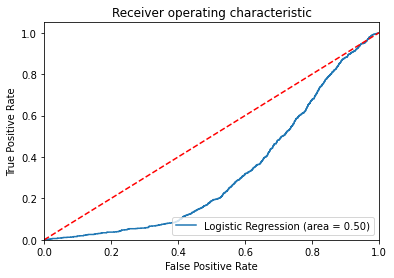

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Testing full dataset

In [60]:
y_predfull = logreg.predict(xfull)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(xfull, yfull)))

Accuracy of logistic regression classifier on test set: 0.32


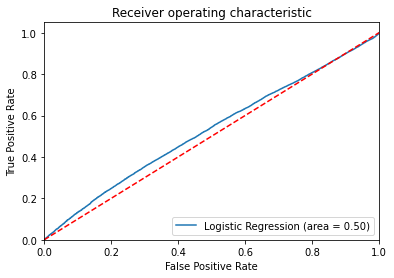

In [61]:
logit_roc_aucfull = roc_auc_score(yfull, logreg.predict(xfull))
fprfull, tprfull, thresholdsfull = roc_curve(yfull, logreg.predict_proba(xfull)[:,1])
plt.figure()
plt.plot(fprfull, tprfull, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Logistic Regression aggregated around merchants

Creating merchants dataframe for logistic regression.

We aggregate data by merchants and orders.

In [62]:
merchant_orders = get_merchant_order_attributes(baskets)

Here, I changed the classifications for merchant, for the logistic regression to run. I'm not sure why the parameter needed to change.

We aggregate by merchants from the set aggregated by merchnats and orders to keep the fields from orders in the frame aggregated by merchants.

In [63]:
merchants2 = get_merchant_attributes2(merchant_orders)

#### Building merchant dataframe for full set.

In [64]:
merchant_orders_full = get_merchant_order_attributes(test_baskets)

In [65]:
merchants2full = get_merchant_attributes2(merchant_orders_full)

### Creating Model

We separate the dataframe into training and testing.

In [66]:
train2, test2,= train_test_split( merchants2, test_size=0.2)

In [67]:
regressiondatamerchant = train2.drop(columns =['merchant_id', 'first_month', 'last_month', 'total_spent', 'num_orders', 'quantity_purchased'])

In [68]:
regressiondatamerchant = regressiondatamerchant.dropna()

In [69]:
X2 = regressiondatamerchant.loc[:, regressiondatamerchant.columns != 'churner']
y2 = regressiondatamerchant.loc[:, regressiondatamerchant.columns == 'churner']

In [70]:
X2.info()
y2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 212 to 286
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avg_unique_sku_per_order      263 non-null    float64
 1   avg_unique_top_cat_per_order  263 non-null    float64
 2   avg_unique_sub_cat_per_order  263 non-null    float64
 3   avg_spent_per_order           263 non-null    float64
 4   tenure_month                  263 non-null    int64  
 5   avg_units_per_order           263 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 14.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 212 to 286
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   churner  263 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


We create a logistic regression function to predict churning. The regressors are average unique SKUs per order (avg_unique_sku_per_order), average unique top categories per order (avg_unique_top_cat_per_order), average unique subcategories per order (avg_unique_sub_cat_per_order), average spend per order (avg_spent_per_order), how many months the merchant has purchased (tenure_month), and the average number of products per order (avg_units_per_order). 

In [71]:
logit_model_merchant=sm.Logit(y2, X2)
result_merchant=logit_model_merchant.fit()
print(result_merchant.summary2())

Optimization terminated successfully.
         Current function value: 0.295964
         Iterations 8
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.417     
Dependent Variable:      churner             AIC:                 167.6772  
Date:                    2022-11-28 09:51    BIC:                 189.1101  
No. Observations:        263                 Log-Likelihood:      -77.839   
Df Model:                5                   LL-Null:             -133.52   
Df Residuals:            257                 LLR p-value:         2.1036e-22
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
avg_u

building test for full dataset

In [72]:
regressiondatamerchantfull = merchants2full.drop(columns =['merchant_id', 'first_month', 'last_month', 'total_spent', 'num_orders', 'quantity_purchased'])
regressiondatamerchantfull = regressiondatamerchantfull.dropna()
xmfull = regressiondatamerchantfull.loc[:, regressiondatamerchantfull.columns != 'churner']
ymfull = regressiondatamerchantfull.loc[:, regressiondatamerchantfull.columns == 'churner']

### Implementing Logistic Regression Model, so it can be evaluated

In [73]:
regressionmodeldatamerchant = merchants2.drop(columns = ['merchant_id', 'first_month', 'last_month', 'total_spent', 'num_orders', 'quantity_purchased'])

In [74]:
regressionmodeldatamerchant = regressionmodeldatamerchant.dropna()

In [75]:
regressionmodeldatamerchant

,avg_unique_sku_per_order,avg_unique_top_cat_per_order,avg_unique_sub_cat_per_order,avg_spent_per_order,tenure_month,avg_units_per_order,churner
0,6.272727,3.272727,3.454545,1.072945e+06,9,9.727273,0.0
1,6.875000,3.875000,4.250000,1.879375e+06,10,11.000000,0.0
2,6.594595,3.567568,3.864865,1.028532e+06,6,15.864865,1.0
3,5.500000,3.000000,3.000000,5.105000e+05,2,5.500000,0.0
4,10.000000,4.500000,5.000000,1.344000e+06,6,10.500000,0.0
...,...,...,...,...,...,...,...
324,2.500000,1.000000,1.000000,9.675000e+05,1,4.500000,0.0
325,18.250000,7.500000,9.500000,4.848775e+06,1,46.750000,0.0
326,2.000000,2.000000,1.500000,4.465000e+05,1,2.500000,0.0
327,14.000000,7.000000,7.400000,1.753800e+06,1,22.000000,0.0


In [76]:
xm = regressionmodeldatamerchant.loc[:, regressionmodeldatamerchant.columns != 'churner']
ym = regressionmodeldatamerchant.loc[:, regressionmodeldatamerchant.columns == 'churner']

In [77]:
Xm_train, Xm_test, ym_train, ym_test = train_test_split(xm, ym, test_size=0.3, random_state=0)
logregm = LogisticRegression()
logregm.fit(Xm_train, ym_train)

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

## Evaluating Logistic Regression, aggregated by merchant

In [78]:
y_predm = logregm.predict(Xm_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregm.score(Xm_test, ym_test)))

Accuracy of logistic regression classifier on test set: 0.83


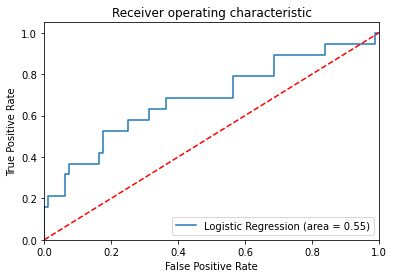

In [79]:
logit_roc_aucm = roc_auc_score(ym_test, logregm.predict(Xm_test))
fprm, tprm, thresholdsm = roc_curve(ym_test, logregm.predict_proba(Xm_test)[:,1])
plt.figure()
plt.plot(fprm, tprm, label='Logistic Regression (area = %0.2f)' % logit_roc_aucm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Evaluating with full dataset

In [80]:
y_predmfull = logregm.predict(xmfull)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregm.score(xmfull, ymfull)))

Accuracy of logistic regression classifier on test set: 0.25


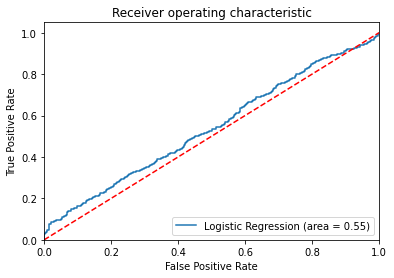

In [81]:
logit_roc_aucmfull = roc_auc_score(ymfull, logregm.predict(xmfull))
fprmfull, tprmfull, thresholdsmfull = roc_curve(ymfull, logregm.predict_proba(xmfull)[:,1])
plt.figure()
plt.plot(fprmfull, tprmfull, label='Logistic Regression (area = %0.2f)' % logit_roc_aucm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### YINGLI:
* the below note has incomplete sentence, giving reader impression that this work is very rushed
* how should computation results be interpreted, and do the results imply that logistic regression is reasonable choice for use for the dataset?

# Computing Correlation Between the Variables within our Dataset

One of the assumptions of logistic regression is that the covariates are 

We have six variables:
- `avg_unique_sku_per_order`,
- `avg_unique_top_cat_per_order`,
- `avg_unique_sub_cat_per_order`,
- `avg_spent_per_order`,
- `tenure_month`,
- `tenure_month`,

and one binary outcome, `churner`.

To compute correlation between each variable and the binary outcome, we can use point biserial correlation, `scipy.stats.pointbiserialr(x,y)`.

$$r_{pb} = \left(\frac{\overline{Y_1} - \overline{Y_2}}{s_Y}\right) \sqrt{\frac{np_0(1-p_0)}{n-1}} $$

where,

$$ s_Y = \sqrt{\frac{∑_{k=1}^n (Y_k - \overline{Y})^2}{n-1}}, $$

$$ p_1 = \left(\frac{1}{n}\right) ∑_{k=1}^n (X_k), $$

and,

$$ p_0 = 1-p_1. $$

**The $X_k$'s are the boolean values.**

More information on this correlation can be found [here](http://www.ce.memphis.edu/7012/L17_CategoricalVariableAssociation.pdf).

Otherwise we can use the pearson correlation coefficient, $\rho$.

In [82]:
from scipy import stats

# Using Our Dataframe Which We Aggregated by Orders

In [83]:
regressiondata.dropna()
colnames2 = list(regressiondata.columns.values)
for i in range(len(colnames2)):
  print("Point Biserial Correlation between churner and " + colnames2[i] + ": ")
  print(stats.pointbiserialr(regressiondata["churner"], regressiondata[colnames2[i]]))
  print("")

Point Biserial Correlation between churner and total_spent: 
PointbiserialrResult(correlation=0.05065102132161562, pvalue=4.123179088903714e-15)

Point Biserial Correlation between churner and quantity_purchased: 
PointbiserialrResult(correlation=0.037992165748819445, pvalue=3.925687399331005e-09)

Point Biserial Correlation between churner and num_skus: 
PointbiserialrResult(correlation=0.17494902922095532, pvalue=3.1121500240340318e-164)

Point Biserial Correlation between churner and month: 
PointbiserialrResult(correlation=-0.04571056282967269, pvalue=1.3955831759635352e-12)

Point Biserial Correlation between churner and churner: 
PointbiserialrResult(correlation=0.9999999999999912, pvalue=0.0)

Point Biserial Correlation between churner and c_tenure: 
PointbiserialrResult(correlation=-0.16883332815292687, pvalue=6.271876328127201e-153)

Point Biserial Correlation between churner and days_since: 
PointbiserialrResult(correlation=0.08117644844171375, pvalue=2.237880612028936e-36)



In [84]:
for i in range(len(colnames2)):
  for j in np.arange(i + 1, 5, 1):
    print("Correlation between: " + colnames2[i] + " and " + colnames2[j])
    print(np.corrcoef(regressiondata[colnames2[i]], regressiondata[colnames2[j]]))
    print("")

Correlation between: total_spent and quantity_purchased
[[1.         0.27424171]
 [0.27424171 1.        ]]

Correlation between: total_spent and num_skus
[[1.         0.50601373]
 [0.50601373 1.        ]]

Correlation between: total_spent and month
[[1.         0.01207836]
 [0.01207836 1.        ]]

Correlation between: total_spent and churner
[[1.         0.05065102]
 [0.05065102 1.        ]]

Correlation between: quantity_purchased and num_skus
[[1.         0.30089129]
 [0.30089129 1.        ]]

Correlation between: quantity_purchased and month
[[ 1.        -0.2325877]
 [-0.2325877  1.       ]]

Correlation between: quantity_purchased and churner
[[1.         0.03799217]
 [0.03799217 1.        ]]

Correlation between: num_skus and month
[[ 1.         -0.06807655]
 [-0.06807655  1.        ]]

Correlation between: num_skus and churner
[[1.         0.17494903]
 [0.17494903 1.        ]]

Correlation between: month and churner
[[ 1.         -0.04571056]
 [-0.04571056  1.        ]]



# Using Our Dataframe Which We Aggregated by Merchants

In [85]:
regressiondatamerchant.dropna()
colnames = list(regressiondatamerchant.columns.values)
#print(colnames)
for i in np.arange(0,7):
  print("Point Biserial Correlation between churner and " + colnames[i] + ": ")
  print(stats.pointbiserialr(regressiondatamerchant["churner"], regressiondatamerchant[colnames[i]]))
  print("")

Point Biserial Correlation between churner and avg_unique_sku_per_order: 
PointbiserialrResult(correlation=-0.11012718661409836, pvalue=0.07460543666051839)

Point Biserial Correlation between churner and avg_unique_top_cat_per_order: 
PointbiserialrResult(correlation=-0.18683741696504252, pvalue=0.002347027193514132)

Point Biserial Correlation between churner and avg_unique_sub_cat_per_order: 
PointbiserialrResult(correlation=-0.19793847777848442, pvalue=0.0012521924620338093)

Point Biserial Correlation between churner and avg_spent_per_order: 
PointbiserialrResult(correlation=-0.05432772894766839, pvalue=0.3802155114822083)

Point Biserial Correlation between churner and tenure_month: 
PointbiserialrResult(correlation=-0.5815866119781992, pvalue=3.361841816870299e-25)

Point Biserial Correlation between churner and avg_units_per_order: 
PointbiserialrResult(correlation=0.18047263883628684, pvalue=0.003314180535465843)

Point Biserial Correlation between churner and churner: 
Pointb

### A Word of Warning
We need to be weary of considering `avg_unique_sku_per_order` and `avg_spent_per_order` in our analysis if we decide to aggregate by merchant statistics.

### YINGLI:
* what does the above comment imply? What is the reason for needing to be weary?
* that is the purpose of the below computation of correlations? Would the results below help decide on the selection of features? 

In [86]:
for i in range(len(colnames)):
  for j in np.arange(i + 1, 6, 1):
    print("Correlation between: " + colnames[i] + " and " + colnames[j])
    print(np.corrcoef(regressiondatamerchant[colnames[i]], regressiondatamerchant[colnames[j]]))
    print("")

Correlation between: avg_unique_sku_per_order and avg_unique_top_cat_per_order
[[1.         0.85162794]
 [0.85162794 1.        ]]

Correlation between: avg_unique_sku_per_order and avg_unique_sub_cat_per_order
[[1.         0.79949527]
 [0.79949527 1.        ]]

Correlation between: avg_unique_sku_per_order and avg_spent_per_order
[[1.         0.41732833]
 [0.41732833 1.        ]]

Correlation between: avg_unique_sku_per_order and tenure_month
[[1.        0.1836164]
 [0.1836164 1.       ]]

Correlation between: avg_unique_sku_per_order and avg_units_per_order
[[1.         0.30369585]
 [0.30369585 1.        ]]

Correlation between: avg_unique_top_cat_per_order and avg_unique_sub_cat_per_order
[[1.         0.97153292]
 [0.97153292 1.        ]]

Correlation between: avg_unique_top_cat_per_order and avg_spent_per_order
[[1.         0.20543736]
 [0.20543736 1.        ]]

Correlation between: avg_unique_top_cat_per_order and tenure_month
[[1.         0.21998638]
 [0.21998638 1.        ]]

Cor

In [87]:
regressiondata.to_csv("by_order.csv")
regressiondatamerchant.to_csv("by_merchant.csv")

# Classification Decision Tree Model

We import the necessary packages to build the decision tree classifier.

In [88]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Decision Tree from df

### YINGLI:
* it would be good to make a separate dataframe for decision trees, as opposed to do "drop columns" on df
* the reader of the code should not need to keep track of when df has what columns

In [89]:
df = df.dropna()
df = df.drop(columns = [ 'merchant_id', 'month', 'since','quantity_purchased'])

We separate the the data from df into an outcome vector and a predictor dataframe, idexed by order_id

In [90]:
X = df.loc[:, df.columns != 'churner']
y = df.loc[:, df.columns == 'churner']

We split the the outcome vector and the predictor dataframe into testing and training datasets. The test size is 20% of the data.

In [91]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2)

Here, we build the decision tree for on the data from df

In [92]:
dtree = DecisionTreeClassifier(random_state = 4, criterion = 'gini', max_depth = 4)
dtree.fit(x_train, y_train)  #train parameters: features and target
pred = dtree.predict(x_test)  #parameter: new data to predict

This gives us the accuracy of the decision tree from df

In [93]:
dtree.score(x_test,y_test)

0.8925

This gives us the confusion matrix of the decision tree from df

In [94]:
623/5377


0.11586386460851776

In [95]:
cm = confusion_matrix(y_test, pred)
print (cm)

[[5355    0]
 [ 645    0]]


Here we create a visualization of the decision tree.

In [96]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('/Users/yingli/Development/DataScienceLifeCycle/datasciencelifecycle/sample_code/tree.png')
#Image(graph.create_png())

In [97]:
### this one should be double checked to see if we need it!

from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)
#parameters: targets to be predicted and predictions from new data used before

0.8925

### Random Forrest Check

In [98]:
from sklearn.ensemble import RandomForestClassifier


rtree = RandomForestClassifier(random_state=1, bootstrap = True, criterion = 'entropy',
                                   max_features = 'auto', min_samples_leaf = 1,
                                   min_samples_split = 5, n_estimators = 500)
rtree.fit(x_train, y_train)  #train parameters: features and target
rpred = rtree.predict(x_test)  #parameter: new data to predict

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_22112/1393499094.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rtree.fit(x_train, y_train)  #train parameters: features and target
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [99]:
rtree.score(x_test,y_test)

0.8855

In [100]:
cm = confusion_matrix(y_test, rpred)
print (cm)

[[5241  114]
 [ 573   72]]


## Decision Tree from df2

We follow similar steps to the previous section, with df2

In [101]:
df2 = df2.drop(columns = ['order_id', 'merchant_id', 'num_top_cats', 'num_sub_cats', 'since', 'month', 'quantity_purchased'])

KeyError: "['num_top_cats', 'num_sub_cats'] not found in axis"

In [ ]:
df2 = df2.dropna()

In [ ]:
A = df2.loc[:, df2.columns != 'churner']
B = df2.loc[:, df2.columns == 'churner']

In [ ]:
a_train, a_test, b_train, b_test = train_test_split(A, B, test_size=.2)

In [ ]:
dtree = DecisionTreeClassifier(random_state = 0, max_depth = 4)
dtree.fit(a_train, b_train)  #train parameters: features and target
pred_a = dtree.predict(a_test)  #parameter: new data to predict

a_train

TypeError: ignored

In [ ]:
accuracy_score_a = accuracy_score(b_test, pred_a)
accuracy_score_a

In [ ]:
pred2 = dtree.predict(a_test)
accuracy_score(b_test, pred2)